In [ ]:
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

species = []
for s in tqdm(range(1, 1000)):
    url = f"https://pokeapi.co/api/v2/pokemon/{s}"
    response = requests.get(url).json()
    stats = {x['stat']['name']: x['base_stat'] for x in response['stats']}
    types = [t['type']['name'] for t in response['types']]

    # get color and generation from species endpoint
    species_url = f"https://pokeapi.co/api/v2/pokemon-species/{s}"
    sp = requests.get(species_url).json()
    color = sp.get("color", {}).get("name")
    generation = sp.get("generation", {}).get("name")

    species.append({
        "id": s,
        "name": response['name'],
        "height": response['height'],
        "weight": response['weight'],
        "types": types,
        "hp": stats.get('hp'),
        "attack": stats.get('attack'),
        "defense": stats.get('defense'),
        "special-attack": stats.get('special-attack'),
        "special-defense": stats.get('special-defense'),
        "speed": stats.get('speed'),
        "total_stats": sum(stats.values()),
        "num_types": len(types),
        "color": color,
        "generation": generation
    })

df = pd.DataFrame(species)
df.head()


100%|██████████| 999/999 [02:16<00:00,  7.34it/s]


,id,name,height,weight,types,hp,attack,defense,special-attack,special-defense,speed,total_stats,num_types,color,generation
0,1,bulbasaur,7,69,"[grass, poison]",45,49,49,65,65,45,318,2,green,generation-i
1,2,ivysaur,10,130,"[grass, poison]",60,62,63,80,80,60,405,2,green,generation-i
2,3,venusaur,20,1000,"[grass, poison]",80,82,83,100,100,80,525,2,green,generation-i
3,4,charmander,6,85,[fire],39,52,43,60,50,65,309,1,red,generation-i
4,5,charmeleon,11,190,[fire],58,64,58,80,65,80,405,1,red,generation-i


# **QUESTION 1**

**Research Question (RQ)**

Do Pokémon color categories align with their elemental “temperature” types (warm vs cool) more strongly in newer generations?

**Operationalization (1 sentence)**

Map each Pokémon’s color and type to one of five aesthetic categories (warm, cool, metallic, mystic, neutral).
A match occurs when both belong to the same category; the average match_rate is calculated per generation.

**Hypotheses**

Null (H₀): There is no increasing trend in color–type temperature alignment across generations.
Formally: Spearman ρ between generation number and match_rate ≤ 0.

Alternative (H₁, one-sided): Color–type temperature alignment increases with generation.
Formally: Spearman ρ between generation number and match_rate > 0.

**Results**

ρ = –0.03, p = 0.932.

Fail to reject the null hypothesis, indicating no statistically significant relationship. The weak correlation is likely due to random variation, suggesting that color–type alignment has not systematically strengthened across generations.

        generation  match_rate
0     generation-i    0.370861
1    generation-ii    0.390000
2   generation-iii    0.385185
3    generation-iv    0.317757
4    generation-ix    0.414894
5     generation-v    0.474359
6    generation-vi    0.458333
7   generation-vii    0.363636
8  generation-viii    0.364583


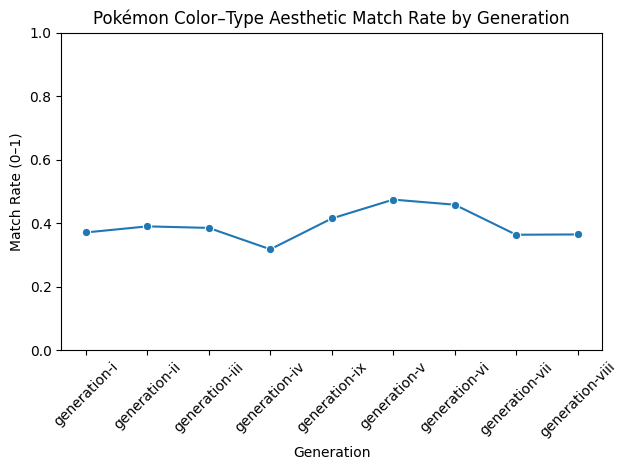

Result: match rate decreases from generation-i (0.37) to generation-viii (0.36). Fail to reject H₀ (ρ=-0.03, negative correlation, p=0.932). No significant change.


In [ ]:
import requests, pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import spearmanr

d = df.dropna(subset=["color","generation"]).copy()

warm_colors = {"red","orange","yellow","pink","brown"}            # fiery / earthy tones
cool_colors = {"blue","white","green","teal","gray"}              # calm / natural tones
metallic_colors = {"black","silver","gray"}                       # mechanical / electric tones
mystic_colors = {"purple","white","cyan"}                         # spiritual / psychic tones
neutral_colors = {"beige","cream"}                                # neutral / organic tones

warm_types = {"fire","fighting","dragon","ground","rock"}          # hot, physical energy
cool_types = {"water","ice","grass","flying","fairy"}              # calm, natural, cool
metallic_types = {"steel","electric","poison"}                     # synthetic or industrial
mystic_types = {"psychic","ghost","dark"}                          # spiritual or mystical
neutral_types = {"normal","bug"}                                   # organic or neutral

def color_temp(c):
    if c in warm_colors: return "warm"
    if c in cool_colors: return "cool"
    if c in metallic_colors: return "metallic"
    if c in mystic_colors: return "mystic"
    if c in neutral_colors: return "neutral"
    return None

def type_temp(types_list):
    tset = {t.lower() for t in types_list}
    if tset & warm_types: return "warm"
    if tset & cool_types: return "cool"
    if tset & metallic_types: return "metallic"
    if tset & mystic_types: return "mystic"
    if tset & neutral_types: return "neutral"
    return None

d["color_temp"] = d["color"].apply(color_temp)
d["type_temp"]  = d["types"].apply(type_temp)
d = d.dropna(subset=["color_temp","type_temp"]).copy()

d["temp_match"] = (d["color_temp"] == d["type_temp"]).astype(int)

# 7) Calculate match rate per generation
match_by_gen = (
    d.groupby("generation")["temp_match"]
     .mean()
     .reset_index()
     .rename(columns={"temp_match":"match_rate"})
     .sort_values("generation")
)

print(match_by_gen)

# 8) Plot trend
sns.lineplot(data=match_by_gen, x="generation", y="match_rate", marker="o")
plt.title("Pokémon Color–Type Aesthetic Match Rate by Generation")
plt.xlabel("Generation")
plt.ylabel("Match Rate (0–1)")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# 9) Spearman correlation
gen_map = {g: i+1 for i, g in enumerate(sorted(d["generation"].unique()))}
match_by_gen["gen_num"] = match_by_gen["generation"].map(gen_map)
rho, p = spearmanr(match_by_gen["gen_num"], match_by_gen["match_rate"])

# 10) Concise conclusion
g_first = match_by_gen.iloc[0]["match_rate"]
g_last  = match_by_gen.iloc[-1]["match_rate"]
trend = "increases" if g_last > g_first else ("decreases" if g_last < g_first else "stays the same")
direction = "positive" if rho > 0 else "negative" if rho < 0 else "no"

if p < 0.05:
    conclusion = f"Reject H₀ (ρ={rho:.2f}, {direction} correlation, p={p:.3f}). Supports H₁."
else:
    conclusion = f"Fail to reject H₀ (ρ={rho:.2f}, {direction} correlation, p={p:.3f}). No significant change."

print(f"Result: match rate {trend} from {match_by_gen.iloc[0]['generation']} ({g_first:.2f}) "
      f"to {match_by_gen.iloc[-1]['generation']} ({g_last:.2f}). {conclusion}")

# **QUESTION 2**

**Research Question (RQ)**

To what extent is a Pokémon’s weight linearly related to its overall strength, and does a heavier body correspond to higher total base stats?

**Operationalization**

For each Pokémon, record its weight (in kilograms) and total base stats (sum of HP, Attack, Defense, Special Attack, Special Defense, and Speed) from the PokéAPI dataset.
Use the Pearson correlation test to measure the strength and direction of the linear relationship between these two variables.

**Hypotheses**

Null Hypothesis (H₀):
There is no significant correlation between a Pokémon’s weight and its total base stats.

Alternative Hypothesis (H₁):
heavier Pokémon has higher total base stats.

**Results**

Pearson = 0.453 → fail to reject h1
p = 1.37e-51< 0.05 → Reject H₀

p-value is below 0.05, reject the null hypothesis. suggests that the relationship is unlikely to be due to random chance, providing evidence that heavier Pokémon tend to have higher base stats. Pearson value indicates a moderate positive relationship.

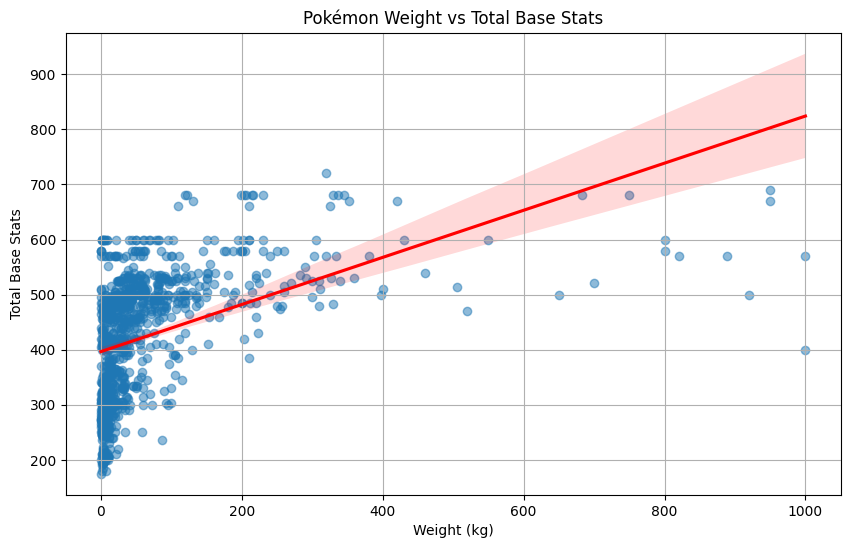

Pearson Correlation (Weight vs Total Base Stats): 0.453

--- Hypothesis Test Result ---
H₀: There is no significant correlation between a Pokémon's weight and its total base stats
H₁: There is a significant correlation between a Pokémon's weight and its total base stats
ρ = 0.45253 → positive correlation
p = 1.373650898134141e-51 < 0.05 → Reject H₀ → Significant relationship.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

#1 Convert weight (hectograms to kilograms)
df["weight_kg"] = df["weight"] / 10.0

#2 Clean data (remove invalid or missing values)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["weight_kg", "total_stats"])
df = df[df["weight_kg"] > 0]

#3 Visualization
plt.figure(figsize=(10,6))
sns.regplot(
    x="weight_kg",
    y="total_stats",
    data=df,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
plt.title("Pokémon Weight vs Total Base Stats")
plt.xlabel("Weight (kg)")
plt.ylabel("Total Base Stats")
plt.grid(True)
plt.show()

#4 Pearson Correlation Test
corr_wt, p_value_wt = pearsonr(df["weight_kg"], df["total_stats"])
print(f"Pearson Correlation (Weight vs Total Base Stats): {corr_wt:.3f}")

alpha = 0.05  # significance level

#5 Hypothesis Test Result
print("\n--- Hypothesis Test Result ---")
print("H₀: There is no significant correlation between a Pokémon's weight and its total base stats")
print("H₁: There is a significant correlation between a Pokémon's weight and its total base stats")

if p_value_wt < alpha:
    direction = "positive" if corr_wt > 0 else "negative"
    print(f"ρ = {corr_wt:.5f} → {direction} correlation")
    print(f"p = {p_value_wt} < {alpha} → Reject H₀ → Significant relationship.")
else:
    print(f"ρ = {corr_wt:.5f}")
    print(f"p = {p_value_wt} ≥ {alpha} → Fail to reject H₀ → No significant relationship.")


# **QUESTION 3**

https://colab.research.google.com/drive/1ZHQI63fPrHQ6xfJs68FQ9OQyEvsA_8eT?usp=sharing

# **Findings**
1. Aggressive Phonological Signals and Stats

Pokémon with aggressive phonological signals (e.g., harsh consonants or suffixes like “-gon,” “-don,” “-zar”) exhibit significantly higher Attack, Speed, and total base stats.

t-test results showed strong evidence:

Attack: Aggressive = 90.14 vs Non-Aggressive = 75.62 (p < 0.001)

Speed: Aggressive = 75.93 vs Non-Aggressive = 67.83 (p < 0.001)

Total Stats: Aggressive = 481.17 vs Non-Aggressive = 421.36 (p < 0.001)

Null hypothesis rejected — Pokémon with aggressive phonological cues are statistically stronger.

2. Weight and Total Base Stats

Pearson correlation coefficient (r = 0.453, p < 0.05)
Indicates a moderate positive relationship: heavier Pokémon tend to have higher total base stats.
Conclusion: p-value < 0.05 → Null hypothesis rejected. The correlation is not random, providing evidence that heavier Pokémon generally have higher base stats.

3. Color–Type Temperature Alignment Over Generations

ρ = –0.03 (very weak negative), p = 0.932
Conclusion: Fail to reject the null hypothesis. The correlation is negligible and likely due to random chance, indicating no meaningful trend in color–type alignment across generations.

# **Conclusion**

Statistical analyses reveal distinct patterns in Pokémon design and attributes. Phonological cues show a strong and significant effect, with aggressively named Pokémon exhibiting higher Attack, Speed, and total base stats. Weight demonstrates a moderate positive correlation with total base stats, indicating that heavier Pokémon tend to be stronger. In contrast, color–type temperature alignment shows no significant trend across generations, suggesting that visual color design changes are largely random rather than systematically evolving.

# **References**

Game Freak. (1996–2025). Pokémon API (PokéAPI). Retrieved from https://pokeapi.co/

Cohen, J. (1988). Statistical power analysis for the behavioral sciences (2nd ed.). Lawrence Erlbaum Associates.

McDonald, J. H. (2014). Handbook of biological statistics (3rd ed.). Sparky House Publishing.

Spearman, C. (1904). The proof and measurement of association between two things. The American Journal of Psychology, 15(1), 72–101. https://doi.org/10.2307/1412159

Pearson, K. (1896). Mathematical contributions to the theory of evolution. III. Regression, heredity, and panmixia. Philosophical Transactions of the Royal Society of London. Series A, 187, 253–318. https://doi.org/10.1098/rsta.1896.0007